# <center> Predicting FPL Player Points via Modeling </center>

In this notebook, we will be taking the cleaned data from the `Data_Cleaning_and_EDA` notebook and create multiple models that will predict the points earned by a player in a given match. The goal is to hopefully have a model that can predict `total_points` better than the FPL `xP` column which will both be compared to the ground truth `total_points`. 

The data we have is from GW 1-24 for the 22/23 Season, for the modelling we will split the train and test sets based on the GW number where we will train on GW 1-20 and test on the following four gameweeks (21-24 GW).

Since the target column `total_points` is a continous variable, we will fitting and evaluating the following models:
- Linear Regression
- Lasso Regression (a Linear Regression model with L1 regularization)
- Random Forest Regressor

In [1]:
import pandas as pd
import numpy as np

np.random.seed(123)

In [2]:
# reading in the clean data and viewing it
df = pd.read_csv('../data/cleaned.csv', index_col=0)
df.head()

,name,position,team,GW,xP,minutes,goals_scored,assists,clean_sheets,saves,...,penalties_missed,goals_conceded,own_goals,yellow_cards,red_cards,influence,creativity,threat,value,total_points
0,Nathan Redmond,MID,Southampton,1,1.5,1,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,55,1
1,Junior Stanislas,MID,Bournemouth,1,1.1,1,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,50,1
2,Armando Broja,FWD,Chelsea,1,2.0,15,0,0,0,0,...,0,0,0,0,0,5.2,0.3,19.0,55,1
3,Fabian Schär,DEF,Newcastle,1,2.4,90,1,0,1,0,...,0,0,0,0,0,66.0,14.6,25.0,45,15
4,Jonny Evans,DEF,Leicester,1,1.9,90,0,0,0,0,...,0,2,0,0,0,14.0,1.3,0.0,45,1


From the cleaned dataset, we still have some preprocessing to do before we can fit this to a model. We need to remove the `xP` column since it is the official FPL's point predicition for the match. Since we are only interested in an individual player's performance, we can drop the `team` column as well and add it back into our dataframe after the model's predicition. Similarly, we will drop the `name` column as we are assuming that a player's name should not affect their performance but we will need their names and team names later during team selection. Lastly, we need to convert the `position` column to a numerical column so that the model can interpret it. It was determined in the EDA notebook that positions have an effect do to the scoring scheme in FPL. 

To summarize, the steps are as follows:

- Convert `position` to numerical via OneHotEncoder
- Split the train and test data based on GW numbers
- Save into a list the `xP`, `GW`, `name`, and `team` of the players
- Drop `xP`, `GW`, `name`, and `team` from the train and test sets 

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [4]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the positions column and transform
pos = pd.DataFrame(df['position'])
encoded = ohe.fit_transform(pos)

# Put into a dataframe to get column names
encoded_df = pd.DataFrame(encoded, columns=['DEF', 'FWD', 'GK', 'MID'], dtype=int)

# Add original back in
model_df = pd.concat([df, encoded_df], axis=1)

# Drop position column
model_df = model_df.drop('position', axis=1)

# Show
model_df.head()

,name,team,GW,xP,minutes,goals_scored,assists,clean_sheets,saves,penalties_saved,...,red_cards,influence,creativity,threat,value,total_points,DEF,FWD,GK,MID
0,Nathan Redmond,Southampton,1,1.5,1,0,0,0,0,0,...,0,0.0,0.0,0.0,55,1,0,0,0,1
1,Junior Stanislas,Bournemouth,1,1.1,1,0,0,0,0,0,...,0,0.0,0.0,0.0,50,1,0,0,0,1
2,Armando Broja,Chelsea,1,2.0,15,0,0,0,0,0,...,0,5.2,0.3,19.0,55,1,0,1,0,0
3,Fabian Schär,Newcastle,1,2.4,90,1,0,1,0,0,...,0,66.0,14.6,25.0,45,15,1,0,0,0
4,Jonny Evans,Leicester,1,1.9,90,0,0,0,0,0,...,0,14.0,1.3,0.0,45,1,1,0,0,0


Since we are splitting the train and test data based on the GW number, we do not need to import the train-test split from sklearn.

In [5]:
# Train test split

X = model_df.drop('total_points', axis = 1)
y = model_df['total_points']

In [6]:
X_train, X_test = X.loc[X['GW'] < 21], X.loc[X['GW'] >= 21]
y_train, y_test = y[:X_train.shape[0]], y[X_train.shape[0]:]

In [7]:
# Sanity check to make sure shapes of train and test sets are consistent
print(f"X_train Shape: {X_train.shape}\ny_train Shape:{y_train.shape}\n\nX_test Shape:{X_test.shape}\ny_test Shape:{y_test.shape}")

X_train Shape: (5916, 23)
y_train Shape:(5916,)

X_test Shape:(1257, 23)
y_test Shape:(1257,)


In [8]:
# saving player names, team, xP, GW number in a list for train and test data

train_names = list(n for n in X_train['name'])
train_teams = list(t for t in X_train['team'])
train_xP = list(x for x in X_train['xP'])
train_GW = list(g for g in X_train['GW'])


test_names = list(n for n in X_test['name'])
test_teams = list(t for t in X_test['team'])
test_xP = list(x for x in X_test['xP'])
test_GW = list(g for g in X_test['GW'])

In [9]:
# Removing names from training and test data
X_train = X_train.drop(['name', 'team', 'xP', 'GW'], axis = 1)
X_test = X_test.drop(['name', 'team', 'xP', 'GW'], axis = 1)

In [10]:
# Scale data with Standard Scaler

ss = StandardScaler()
ss.fit(X_train)

X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

## Linear Regression Model

In [11]:
LR_model = LinearRegression()
LR_model.fit(X_train_scaled, y_train)

LinearRegression()

R^2 of the Linear Regression for train data: 0.8703524975724928
R^2 of the Linear Regression for test data: 0.8548425633013981


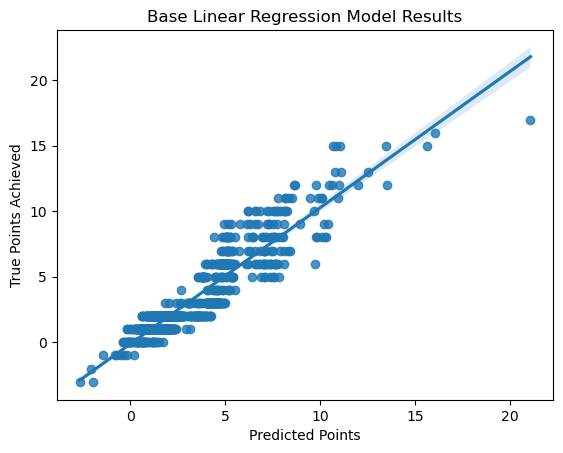

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

print(f"R^2 of the Linear Regression for train data: {LR_model.score(X_train_scaled, y_train)}")
print(f"R^2 of the Linear Regression for test data: {LR_model.score(X_test_scaled, y_test)}")

plt.figure()
sns.regplot(x=LR_model.predict(X_test_scaled), y=y_test)
plt.title('Base Linear Regression Model Results')
plt.xlabel('Predicted Points')
plt.ylabel('True Points Achieved')
plt.show()

## Determining Hyperparameters for Lasso Regression

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from tempfile import mkdtemp

# Cross-validation with time series split to split the folds by the number of gameweeks in the training set.
X = X_train.values
tsc = TimeSeriesSplit(n_splits=20)

# Save pipeline parameters in temperary directory
cachedir = mkdtemp()

# placeholders for pipeline
estimators = [('normalise', StandardScaler()),
              ('model', LinearRegression())]

# Initializing pipeline
pipe = Pipeline(estimators, memory = cachedir)

# parameter grid for finding best model and hyperparameters for our data
param_grid = [
            {'model': [LinearRegression()], 
             'normalise': [StandardScaler(), MinMaxScaler(), None]},
            {'model': [Lasso()],
             'normalise': [StandardScaler(), MinMaxScaler(), None],
             'model__alpha': [0.001, 0.01, 1, 5, 10]
            }
]

# Cross Validation based on Time Series Split by number of GWs
grid = GridSearchCV(pipe, param_grid, cv=tsc.split(X))

fittedgrid = grid.fit(X_train, y_train)

In [14]:
fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\FARHAN~1\\AppData\\Local\\Temp\\tmpkp5e1fwh',
         steps=[('normalise', None), ('model', Lasso(alpha=0.001))])

In [15]:
# Fitting the Lasso Regression with the best parameters from grid search

LM = Lasso(alpha=0.001)
LM.fit(X_train, y_train)

Lasso(alpha=0.001)

R^2 of the Lasso Model for train data: 0.8701593166196246
R^2 of the Lasso Model for test data: 0.8553304149783999


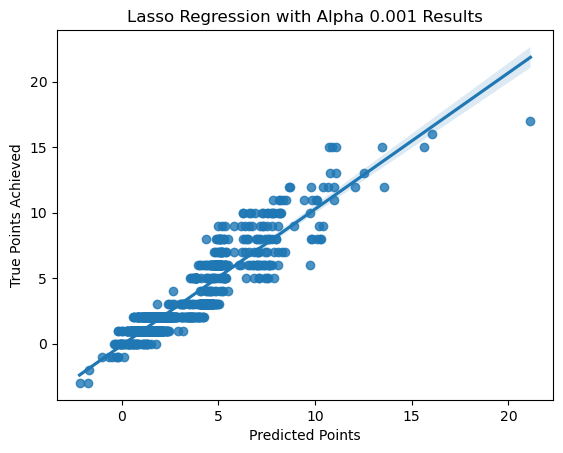

In [16]:
print(f"R^2 of the Lasso Model for train data: {LM.score(X_train, y_train)}")
print(f"R^2 of the Lasso Model for test data: {LM.score(X_test, y_test)}")

plt.figure()
sns.regplot(x=LM.predict(X_test), y=y_test)
plt.title('Lasso Regression with Alpha 0.001 Results')
plt.xlabel('Predicted Points')
plt.ylabel('True Points Achieved')
plt.show()

In [17]:
from sklearn.ensemble import RandomForestRegressor

RFR = RandomForestRegressor()
RFR.fit(X_train, y_train)

print(f"Train:{RFR.score(X_train, y_train)}\nTest:{RFR.score(X_test, y_test)}")

Train:0.9949424694936725
Test:0.9673090885944144


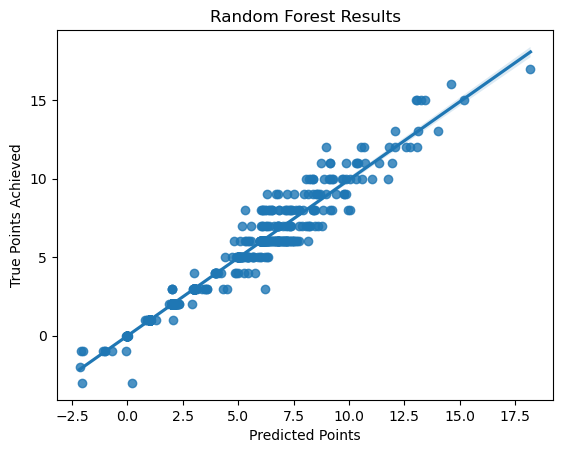

In [18]:
plt.figure()
sns.regplot(x=RFR.predict(X_test), y=y_test)
plt.title('Random Forest Results')
plt.xlabel('Predicted Points')
plt.ylabel('True Points Achieved')
plt.show()

In [19]:
# Cross-validation with time series split to split the folds by the number of gameweeks in the training set.
X = X_train.values
tsc = TimeSeriesSplit(n_splits=20)

# Save pipeline parameters in temperary directory
cachedir = mkdtemp()

# placeholders for pipeline
estimators = [('normalise', StandardScaler()),
              ('model', RandomForestRegressor())]

# Initializing pipeline
pipe = Pipeline(estimators, memory = cachedir)

# parameter grid for finding best model and hyperparameters for our data
param_grid = [
            {'model': [RandomForestRegressor()], 
             'normalise': [StandardScaler(), MinMaxScaler(), None],
             'model__n_estimators': [i for i in range(50, 100, 50)],
             'model__max_depth': [i for i in range(2, 10, 2)],
             }
]

# Cross Validation based on Time Series Split by number of GWs
grid = GridSearchCV(pipe, param_grid, cv=tsc.split(X))

fittedgrid = grid.fit(X_train, y_train)

In [20]:
fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\FARHAN~1\\AppData\\Local\\Temp\\tmpc_ev5qc0',
         steps=[('normalise', StandardScaler()),
                ('model', RandomForestRegressor(max_depth=8, n_estimators=50))])

In [21]:
RFR = RandomForestRegressor(max_depth = 8, n_estimators=50)

RFR.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=8, n_estimators=50)

Train:0.9740520676913855
Test:0.9617606500098749


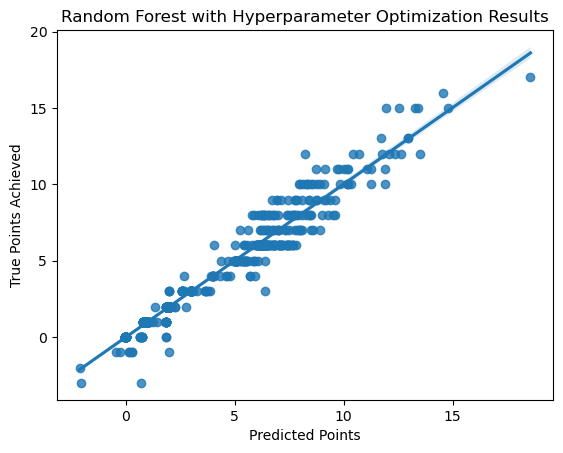

In [22]:
print(f"Train:{RFR.score(X_train_scaled, y_train)}\nTest:{RFR.score(X_test_scaled, y_test)}")

plt.figure()
sns.regplot(x=RFR.predict(X_test_scaled), y=y_test)
plt.title('Random Forest with Hyperparameter Optimization Results')
plt.xlabel('Predicted Points')
plt.ylabel('True Points Achieved')
plt.show()